In [ ]:
from importlib import reload
import matplotlib.pyplot as plt

import numpy as np
import sys

sys.path.append("..")
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [ ]:
import Final_nn_classes as nn
import io_util

In [ ]:
reload(nn)
reload(io_util)

data = io_util.load_mnist("/content", maximum=(5000, 10_000, 10_000))
print(data)

MnistDataSet
  train  -> X: (5000, 784) float32 | Y: (5000,) int64
  val    -> X: (10000, 784) float32 | Y: (10000,) int64
  test   -> X: (10000, 784) float32 | Y: (10000,) int64


In [ ]:
reload(nn)
model = nn.FeedForwardNNWithLayers(
    [13],
    loss_fn=nn.MSELoss(),
    act_fn_hidden=nn.Sigmoid,
    act_fn_out=nn.Sigmoid,
)

print(model)

x_dummy = np.arange(784 * 2).reshape((2, -1)) / 2000
y_dummy = np.arange(10 * 2).reshape((2, -1)) / 2000
yhat = model.forward(x_dummy)

grad, loss = model.backprop(x_dummy, y_dummy)
grad[0][0].shape

FFN (10345 params)
  input: 784
  FFLayerSimple(13 nodes) f=Sigmoid
  FFLayerSimple(10 nodes) f=Sigmoid


(13, 784)

In [ ]:
## It seems to learn something

reload(nn)

model = nn.FeedForwardNNWithLayers(
    [16],
    loss_fn=nn.MSELoss(),
    act_fn_hidden=nn.Sigmoid,
    act_fn_out=nn.Sigmoid,
)

# ReLu seems to work but needs lower LR!

print(model)

trainer = nn.Training(
    model,
    data,
    bs_train=64,
    start_lr=2,
    stop_patience=20,
)

# interesting: random seems better than shuffle, at least on small data.
metrics = trainer.run(max_iter=10, verbose=True, sample_mode="random")


FFN (12730 params)
  input: 784
  FFLayerSimple(16 nodes) f=Sigmoid
  FFLayerSimple(10 nodes) f=Sigmoid
Train DL: 5000 samples = 78 batches x 64
Val   DL: 10000 samples = 1 batches x 10000
epoch=   0 | loss_mean_train=0.0406 | loss_mean_val=0.0321 | samples/second 19723 | acc_val=56.2% | lr: 2
epoch=   1 | loss_mean_train=0.0265 | loss_mean_val=0.0226 | samples/second 19969 | acc_val=73.0% | lr: 2
epoch=   2 | loss_mean_train=0.0196 | loss_mean_val=0.0177 | samples/second 17833 | acc_val=83.2% | lr: 2
epoch=   3 | loss_mean_train=0.0156 | loss_mean_val=0.0146 | samples/second 20185 | acc_val=86.4% | lr: 2
epoch=   4 | loss_mean_train=0.0132 | loss_mean_val=0.0128 | samples/second 19923 | acc_val=87.5% | lr: 2
epoch=   5 | loss_mean_train=0.0114 | loss_mean_val=0.0116 | samples/second 20130 | acc_val=88.1% | lr: 2
epoch=   6 | loss_mean_train=0.0105 | loss_mean_val=0.0107 | samples/second 20614 | acc_val=88.6% | lr: 2
epoch=   7 | loss_mean_train=0.0092 | loss_mean_val=0.0101 | samples/

## Attack

epoch=   0 | loss_mean_train=0.0034 | loss_mean_val=0.0099 | samples/second 21772 | acc_val=89.2% | lr: 2
epoch=   1 | loss_mean_train=0.0049 | loss_mean_val=0.0101 | samples/second 18434 | acc_val=88.6% | lr: 2
epoch=   2 | loss_mean_train=0.0056 | loss_mean_val=0.0098 | samples/second 21384 | acc_val=89.0% | lr: 2
epoch=   3 | loss_mean_train=0.0037 | loss_mean_val=0.0102 | samples/second 20198 | acc_val=87.8% | lr: 2
epoch=   4 | loss_mean_train=0.0034 | loss_mean_val=0.0096 | samples/second 19096 | acc_val=88.7% | lr: 2


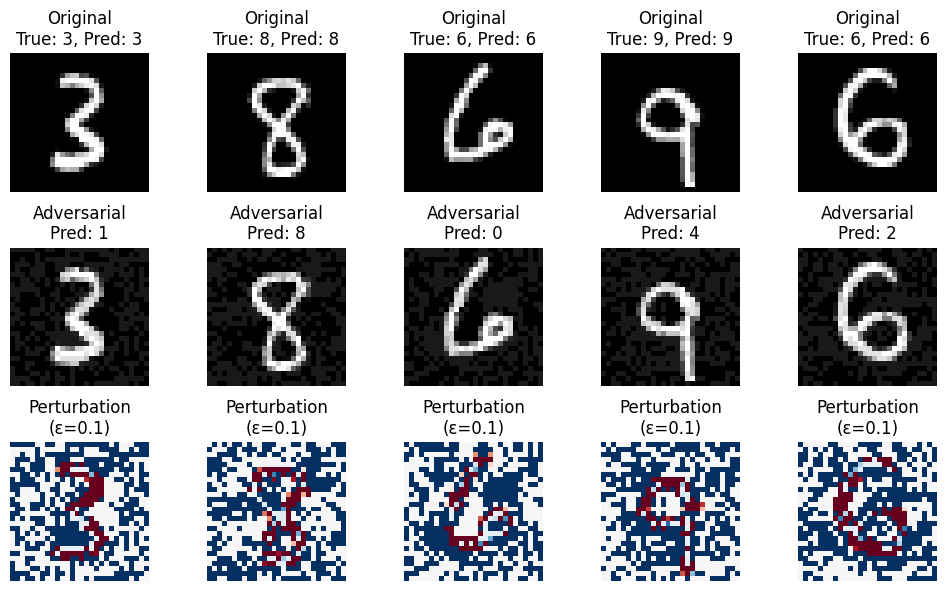

In [ ]:
import attack_class

reload(attack_class)
metrics = trainer.run(max_iter=5, verbose=True)
dl_val = nn.DataLoader(data.val.X, data.val.Y, len(data.val))
attack = attack_class.NetworkAttack(model)
x_test, y_test = dl_val.get_batch(0)
attack.plot_attack_examples(x_test, y_test, epsilon=0.1, n_examples=5)


##flip rate (with and without clip)

Clipping enforces the L∞-ball constraint and keeps examples in the valid input domain, so the attack tests model fragility realistically rather than exploiting invalid input values.

In [ ]:
# two attacked sets: clipped and unclipped
X_adv_unclipped = X_demo + pert
X_adv_clipped   = np.clip(X_demo + pert, 0.0, 1.0)

# predictions
pred_clean = np.argmax(model.forward(X_demo), axis=1)
pred_uncl  = np.argmax(model.forward(X_adv_unclipped), axis=1)
pred_clp   = np.argmax(model.forward(X_adv_clipped), axis=1)

flip_uncl = np.mean(pred_clean != pred_uncl)
flip_clp  = np.mean(pred_clean != pred_clp)

print(f"Flip rate (unclipped): {flip_uncl:.1%}")
print(f"Flip rate (clipped):   {flip_clp:.1%}")

Flip rate (unclipped): 75.0%
Flip rate (clipped):   62.5%


### Task 5a: Generate adversarial training data and retrain


generates FGSM adversarial examples, mixes them with clean examples, trains a new model on the mixed set, compares robustness of original vs adversarially trained model under FGSM, implements a simple PGD attacker for stronger tests, and visualizes examples.


###

Original train size: 5000, Mixed train size: 10000
Train DL: 10000 samples = 312 batches x 32
Val   DL: 10000 samples = 1 batches x 10000

=== Training robust model on mixed dataset (FGSM 50/50) ===
epoch=   0 | loss_mean_train=0.0698 | loss_mean_val=0.0610 | samples/second 7154 | acc_val=26.3% | lr: 0.01
epoch=   1 | loss_mean_train=0.0490 | loss_mean_val=0.0488 | samples/second 8711 | acc_val=40.7% | lr: 0.01
epoch=   2 | loss_mean_train=0.0385 | loss_mean_val=0.0426 | samples/second 8677 | acc_val=49.3% | lr: 0.01
epoch=   3 | loss_mean_train=0.0363 | loss_mean_val=0.0383 | samples/second 8665 | acc_val=56.2% | lr: 0.01
epoch=   4 | loss_mean_train=0.0364 | loss_mean_val=0.0372 | samples/second 8689 | acc_val=57.8% | lr: 0.01
epoch=   5 | loss_mean_train=0.0320 | loss_mean_val=0.0345 | samples/second 8806 | acc_val=63.3% | lr: 0.01
epoch=   6 | loss_mean_train=0.0312 | loss_mean_val=0.0331 | samples/second 8802 | acc_val=65.2% | lr: 0.01
epoch=   7 | loss_mean_train=0.0325 | loss_me

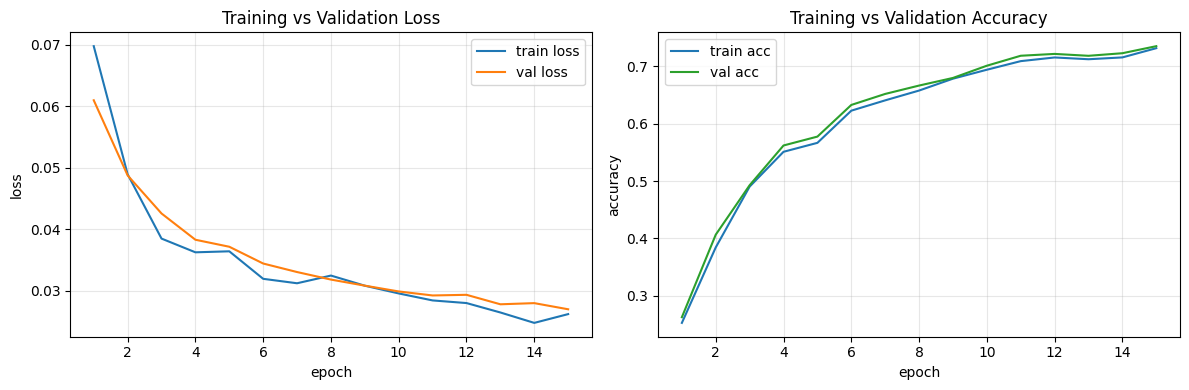

In [ ]:
class Split:
    def __init__(self, X, Y):
        assert X.ndim == 2
        Y = np.asarray(Y).astype(int).reshape(-1)  # ensure 1-D ints
        assert len(X) == len(Y)
        self.X = X.astype(np.float32)
        self.Y = Y
    def __len__(self):
        return len(self.X)

class SimpleData:
    pass

# Ensure classes are loaded
try:
    FeedForwardNNWithLayers; MSELoss; Sigmoid; Ident; Training
except NameError:
    from Final_nn_classes import FeedForwardNNWithLayers, MSELoss, Sigmoid, Ident, Training

# --- tiny helper ---   # to handle both cases correctly (INT for DataLoader, one-hot for loss/attack).
def to_onehot(y_int, C=10):
    y_oh = np.zeros((len(y_int), C), dtype=np.float32)
    y_oh[np.arange(len(y_int)), y_int] = 1.0
    return y_oh

# --- 1) FGSM adversarial data from your original model ---
attack = attack_class.NetworkAttack(model)

X_train = data.train.X.astype(np.float32)
Y_train = data.train.Y.astype(int)
Y_train_oh = to_onehot(Y_train, 10)

epsilon = 0.1
X_adv = attack.fgsm_attack(X_train, Y_train_oh, epsilon).astype(np.float32)

# --- 2) 50/50 mixed dataset (keep INT labels for DataLoader) ---
X_mixed = np.vstack([X_train, X_adv]).astype(np.float32)
Y_mixed = np.hstack([Y_train, Y_train]).astype(int)
print(f"Original train size: {len(X_train)}, Mixed train size: {len(X_mixed)}")

# Build data object compatible with your Training/DataLoader
adv_data = SimpleData()
adv_data.train = Split(X_mixed,        Y_mixed)
adv_data.val   = Split(data.val.X,     data.val.Y)
adv_data.test  = Split(data.test.X,    data.test.Y)

# --- 3) Train a fresh model on the mixed dataset ---
model_robust = FeedForwardNNWithLayers(
    hidden_sizes=[30], d_in=784, d_out=10,
    loss_fn=MSELoss(), act_fn_hidden=Sigmoid, act_fn_out=Ident, seed=42
)

trainer = Training(model_robust, adv_data, bs_train=32, start_lr=0.01)

# Record TRAIN accuracy per epoch via epoch_callback (no class edits needed)
acc_train_hist = []
def on_epoch(_info):
    yhat_tr = model_robust.forward(adv_data.train.X)
    acc_tr = float((np.argmax(yhat_tr, axis=1) == adv_data.train.Y).mean())
    acc_train_hist.append(acc_tr)

print("\n=== Training robust model on mixed dataset (FGSM 50/50) ===")
num_epochs = 15
metrics = trainer.run(max_iter=num_epochs, verbose=True, epoch_callback=on_epoch)

# --- 4) Curves: loss & accuracy (simple & tidy) ---
epochs = np.arange(1, len(metrics["loss_train"]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(epochs, metrics["loss_train"], label="train loss")
axes[0].plot(epochs, metrics["loss_val"],   label="val loss")
axes[0].set_xlabel("epoch"); axes[0].set_ylabel("loss")
axes[0].set_title("Training vs Validation Loss")
axes[0].grid(True, alpha=0.3); axes[0].legend()

# Accuracy curves
axes[1].plot(epochs, acc_train_hist,          label="train acc", color="tab:blue")
axes[1].plot(epochs, metrics["acc_val"],      label="val acc",   color="tab:green")
axes[1].set_xlabel("epoch"); axes[1].set_ylabel("accuracy")
axes[1].set_title("Training vs Validation Accuracy")
axes[1].grid(True, alpha=0.3); axes[1].legend()

plt.tight_layout(); plt.show()

#

=== Generating adversarial training data ===
Original train: 5000 | Mixed train: 10000
Train DL: 10000 samples = 312 batches x 32
Val   DL: 10000 samples = 1 batches x 10000

=== Training robust model (15 epochs) ===
epoch=   0 | loss_mean_train=0.0709 | loss_mean_val=0.0587 | samples/second 3036 | acc_val=31.1% | lr: 0.01
epoch 01 | train_loss=0.0567 val_loss=0.0587 | train_acc=30.38% val_acc=31.14%
epoch=   0 | loss_mean_train=0.0467 | loss_mean_val=0.0472 | samples/second 11246 | acc_val=42.7% | lr: 0.01
epoch 02 | train_loss=0.0467 val_loss=0.0472 | train_acc=41.46% val_acc=42.67%
epoch=   0 | loss_mean_train=0.0422 | loss_mean_val=0.0425 | samples/second 10964 | acc_val=49.9% | lr: 0.01
epoch 03 | train_loss=0.0419 val_loss=0.0425 | train_acc=49.08% val_acc=49.91%
epoch=   0 | loss_mean_train=0.0374 | loss_mean_val=0.0377 | samples/second 11242 | acc_val=58.7% | lr: 0.01
epoch 04 | train_loss=0.0382 val_loss=0.0377 | train_acc=56.27% val_acc=58.74%
epoch=   0 | loss_mean_train=0.0

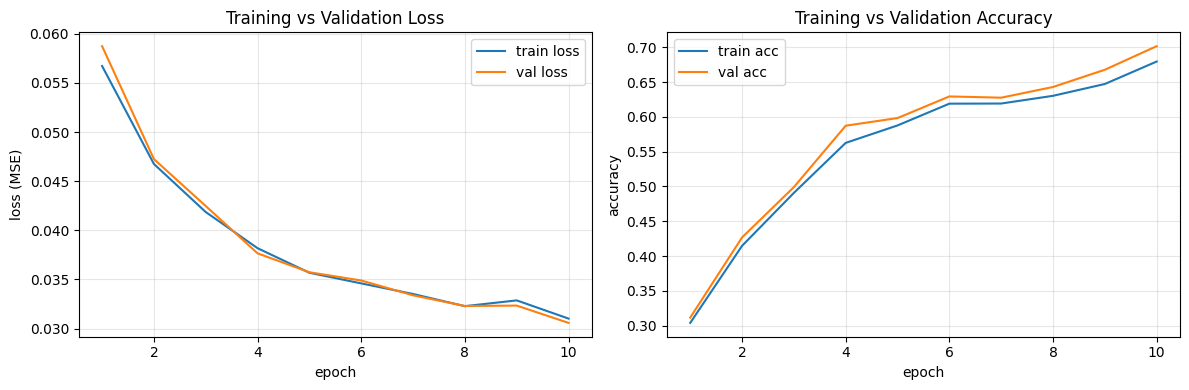


=== Visualizing FGSM examples on robust model ===


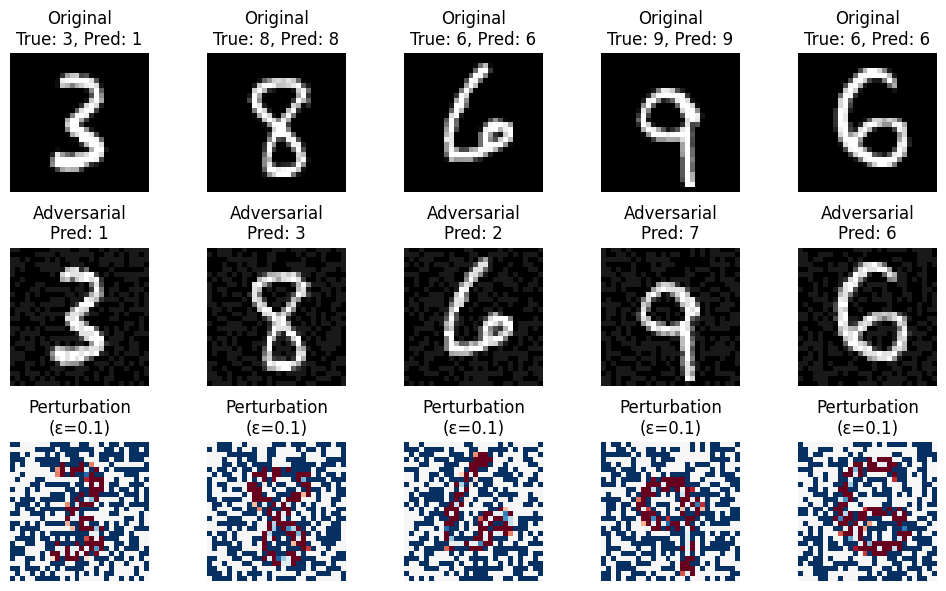

In [ ]:
# PGD with random start
class PGDAttack:
    def __init__(self, model, basic_attack_cls):
        self.model = model
        self.basic = basic_attack_cls(model)

    def attack(self, x, y_oh, eps=0.1, alpha=0.01, steps=10, random_start=True, rng=None):
        if rng is None: rng = np.random.default_rng()
        x_adv = np.clip(x + (rng.uniform(-eps, eps, x.shape) if random_start else 0), 0, 1)
        for _ in range(steps):
            g = self.basic._input_gradient(x_adv, y_oh)
            x_adv = x_adv + alpha * np.sign(g)
            x_adv = np.clip(x + np.clip(x_adv - x, -eps, eps), 0, 1)
        return x_adv

# ----------------- 1) Adversarial training data (FGSM, once) -----------------
print("=== Generating adversarial training data ===")
X_train = data.train.X.astype(np.float32)
Y_train_int = data.train.Y.astype(int)
Y_train_oh  = to_onehot(Y_train_int, 10)

epsilon = 0.1
fgsm = attack_class.NetworkAttack(model)
X_train_adv = fgsm.fgsm_attack(X_train, Y_train_oh, epsilon).astype(np.float32)

# Mixed 50/50 dataset
X_mixed      = np.vstack([X_train, X_train_adv]).astype(np.float32)
mixed_Y_oh   = np.vstack([Y_train_oh, Y_train_oh]).astype(np.float32)  # for MSELoss
Y_mixed_int  = np.hstack([Y_train_int, Y_train_int]).astype(int)        # for accuracy

print(f"Original train: {len(X_train)} | Mixed train: {len(X_mixed)}")

# ----------------- 2) Train robust model (quiet, short) -----------------
model_robust = nn.FeedForwardNNWithLayers(
    hidden_sizes=[30], d_in=784, d_out=10,
    loss_fn=nn.MSELoss(), act_fn_hidden=nn.Sigmoid, act_fn_out=nn.Ident, seed=42
)

class SimpleDataset:
    def __init__(self, X, Y):  # Y = one-hot for MSE
        self.X, self.Y = X, Y

adv_data = type('D', (), {})()
adv_data.train = SimpleDataset(X_mixed, Y_mixed_int) # Pass integer labels here
adv_data.val   = data.val
adv_data.test  = data.test

trainer = nn.Training(model_robust, adv_data, bs_train=32, start_lr=0.01)

print("\n=== Training robust model (15 epochs) ===")
num_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

X_val = data.val.X.astype(np.float32)
Y_val_int = data.val.Y.astype(int)
Y_val_oh  = to_onehot(Y_val_int, 10)

for ep in range(1, num_epochs + 1):
    trainer.run(max_iter=1, verbose=False)  # one quiet epoch
    # log concise metrics
    tr_loss = eval_loss_mse(model_robust, X_mixed, mixed_Y_oh)
    va_loss = eval_loss_mse(model_robust, X_val,   Y_val_oh)
    tr_acc  = eval_accuracy (model_robust, X_mixed, Y_mixed_int)
    va_acc  = eval_accuracy (model_robust, X_val,   Y_val_int)
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    print(f"epoch {ep:02d} | train_loss={tr_loss:.4f} val_loss={va_loss:.4f} "
          f"| train_acc={tr_acc:.2%} val_acc={va_acc:.2%}")

# ----------------- 3) Robustness comparison (FGSM & PGD) on val set -----------------
print("\n=== Robustness comparison on validation set ===")
# FGSM
fgsm_orig = attack_class.NetworkAttack(model)
fgsm_rob  = attack_class.NetworkAttack(model_robust)

def fgsm_metrics(m, atk, X, y_int, eps=0.1):
    y_oh = to_onehot(y_int, 10)
    pred_clean = np.argmax(m.forward(X), axis=1)
    X_adv = atk.fgsm_attack(X, y_oh, eps)
    pred_adv = np.argmax(m.forward(X_adv), axis=1)
    flip = float(np.mean(pred_clean != pred_adv))
    acc_adv = float(np.mean(pred_adv == y_int))
    return flip, acc_adv

flip_o_fgsm, acc_o_fgsm = fgsm_metrics(model,        fgsm_orig, X_val, Y_val_int, epsilon)
flip_r_fgsm, acc_r_fgsm = fgsm_metrics(model_robust, fgsm_rob,  X_val, Y_val_int, epsilon)
print(f"FGSM  | flip: original {flip_o_fgsm:.1%} → robust {flip_r_fgsm:.1%} "
      f"| adv acc: original {acc_o_fgsm:.1%} → robust {acc_r_fgsm:.1%}")

# PGD (random start)
pgd_orig = PGDAttack(model,        attack_class.NetworkAttack)
pgd_rob  = PGDAttack(model_robust, attack_class.NetworkAttack)
Y_val_oh = to_onehot(Y_val_int, 10)

X_pgd_o = pgd_orig.attack(X_val, Y_val_oh, eps=epsilon, alpha=0.01, steps=10, random_start=True)
X_pgd_r = pgd_rob.attack (X_val, Y_val_oh, eps=epsilon, alpha=0.01, steps=10, random_start=True)

acc_o_pgd = eval_accuracy(model,        X_pgd_o, Y_val_int)
acc_r_pgd = eval_accuracy(model_robust, X_pgd_r, Y_val_int)
flip_o_pgd = float(np.mean(np.argmax(model.forward(X_val), axis=1) != np.argmax(model.forward(X_pgd_o), axis=1)))
flip_r_pgd = float(np.mean(np.argmax(model_robust.forward(X_val), axis=1) != np.argmax(model_robust.forward(X_pgd_r), axis=1)))
print(f"PGD   | flip: original {flip_o_pgd:.1%} → robust {flip_r_pgd:.1%} "
      f"| adv acc: original {acc_o_pgd:.1%} → robust {acc_r_pgd:.1%}")

# ----------------- 4) Curves (loss & accuracy) -----------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
e = np.arange(1, num_epochs + 1)

axes[0].plot(e, train_losses, label="train loss")
axes[0].plot(e, val_losses,   label="val loss")
axes[0].set_xlabel("epoch"); axes[0].set_ylabel("loss (MSE)")
axes[0].set_title("Training vs Validation Loss"); axes[0].grid(True, alpha=0.3); axes[0].legend()

axes[1].plot(e, train_accs, label="train acc")
axes[1].plot(e, val_accs,   label="val acc")
axes[1].set_xlabel("epoch"); axes[1].set_ylabel("accuracy")
axes[1].set_title("Training vs Validation Accuracy"); axes[1].grid(True, alpha=0.3); axes[1].legend()

plt.tight_layout(); plt.show()

# ----------------- 5) Example images (FGSM on robust model) -----------------
print("\n=== Visualizing FGSM examples on robust model ===")
fgsm_rob.plot_attack_examples(X_val, to_onehot(Y_val_int, 10), epsilon=epsilon, n_examples=5)

#Task 7

In [ ]:
import hyper
from hyper import HyperparamStudy

reload(hyper)
study = HyperparamStudy(data)

# study.test_architecture(
#     [
#         [16],
#         [32],
#         [16, 16],
#     ]
# )
study.test_learning_rates([0.5, 1, 5])


Testing learning rate: 0.5
Train DL: 5000 samples = 156 batches x 32
Val   DL: 10000 samples = 1 batches x 10000
epoch=  14 | loss_mean_train=0.0192 | loss_mean_val=0.0255 | samples/second 11365 | acc_val=55.0% | lr: 0.5
Best accuracy: 0.579

Testing learning rate: 1
Train DL: 5000 samples = 156 batches x 32
Val   DL: 10000 samples = 1 batches x 10000
epoch=  14 | loss_mean_train=nan | loss_mean_val=nan | samples/second 11522 | acc_val=9.9% | lr: 1
Best accuracy: 0.099

Testing learning rate: 5
Train DL: 5000 samples = 156 batches x 32
Val   DL: 10000 samples = 1 batches x 10000
epoch=  14 | loss_mean_train=nan | loss_mean_val=nan | samples/second 11490 | acc_val=9.9% | lr: 5
Best accuracy: 0.099

Best learning rate: 0.5 (acc: 0.579)


[{'lr': 0.5, 'accuracy': np.float64(0.5785)},
 {'lr': 1, 'accuracy': np.float64(0.0991)},
 {'lr': 5, 'accuracy': np.float64(0.0991)}]

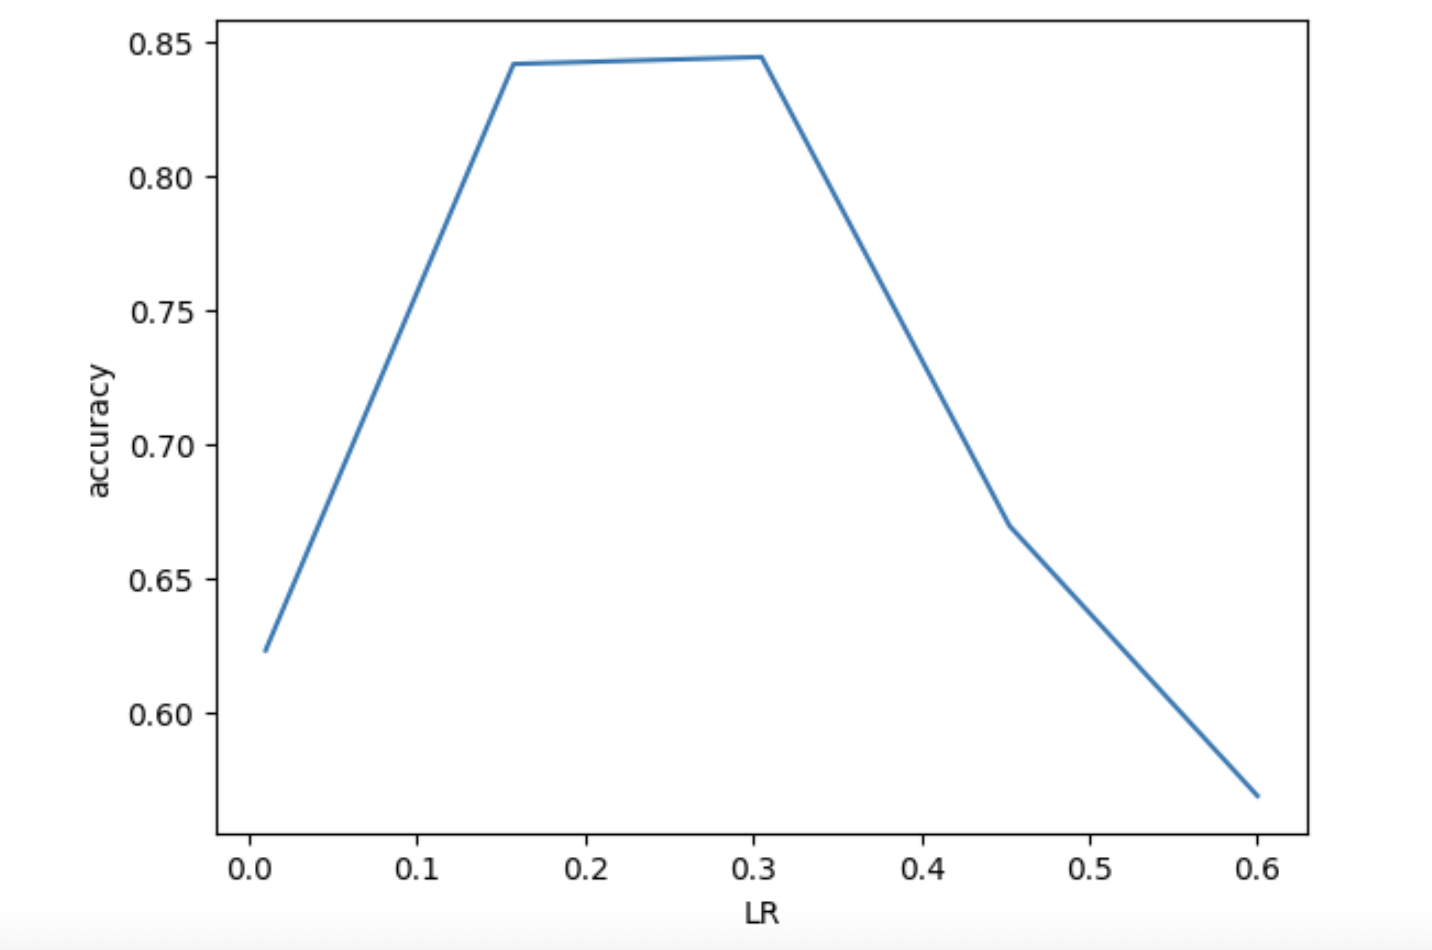

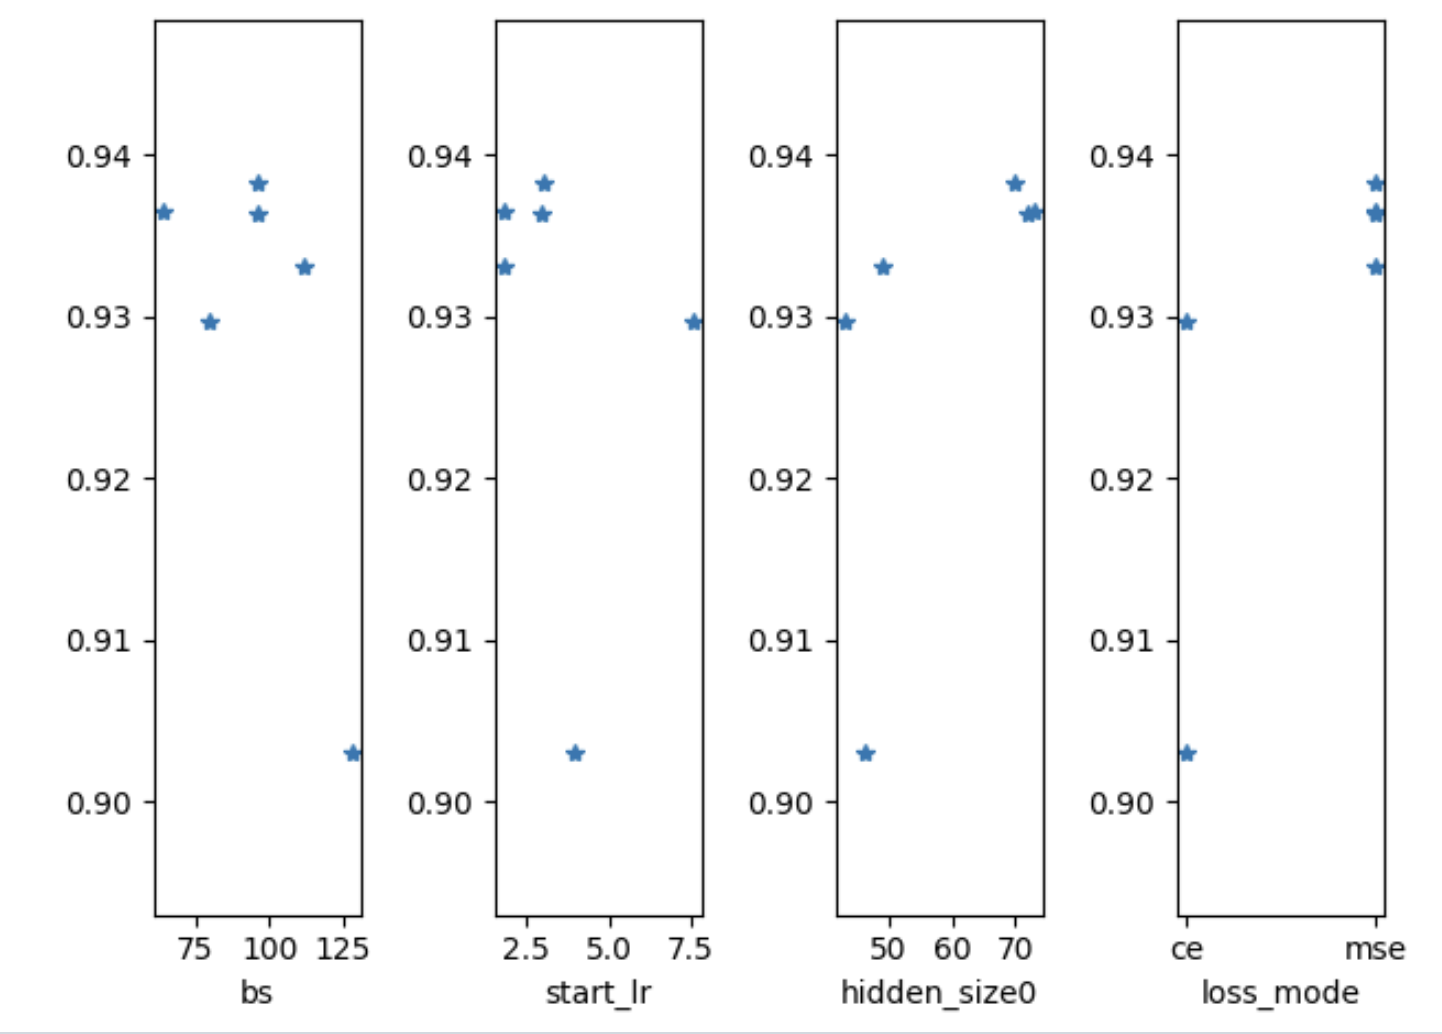

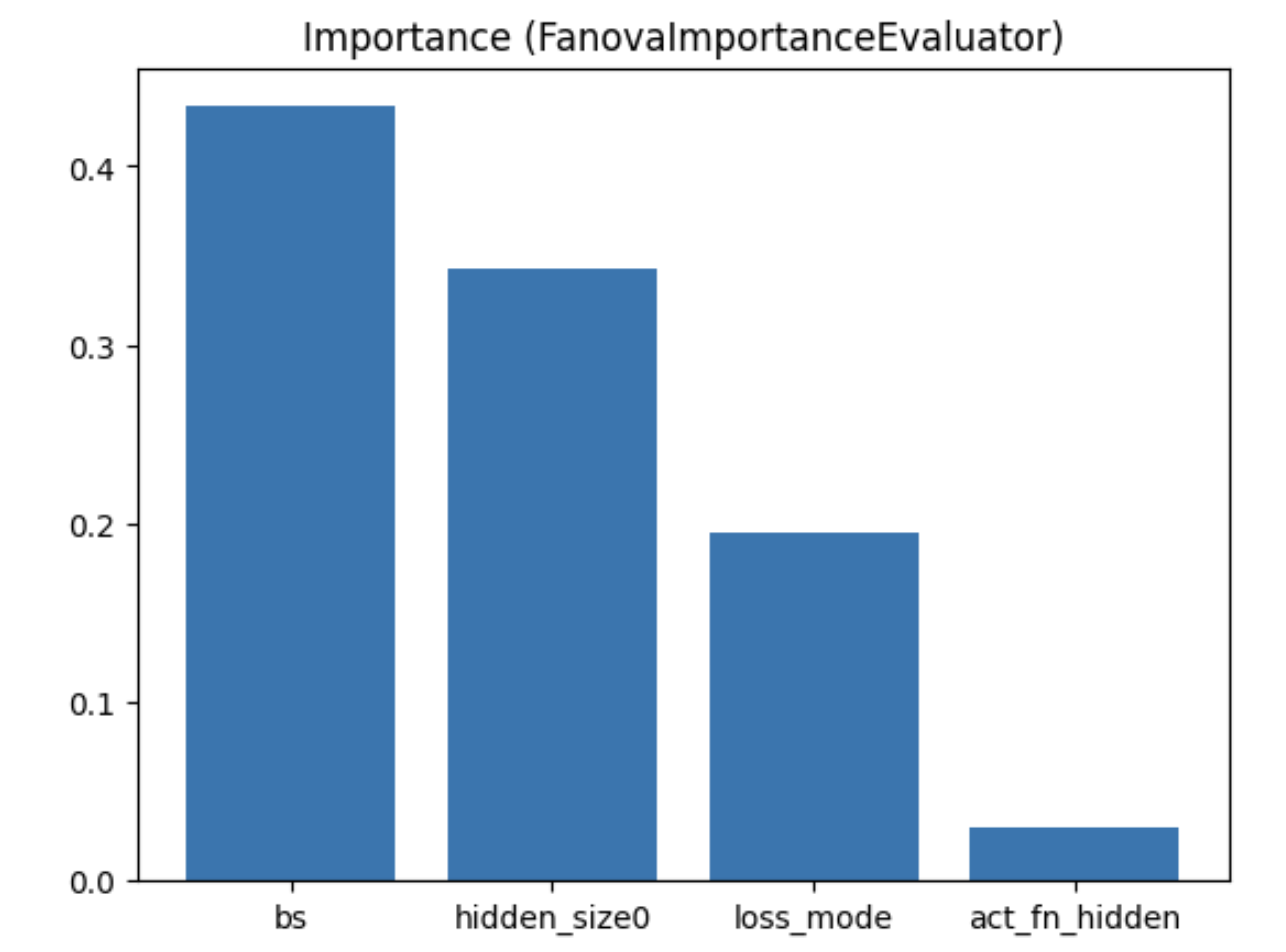